<span style="font-size: 24px; font-weight: bold">第五章·支持向量机</span>

主要目的：
1. 学习支持向量机的核心概念
2. 怎么使用这个模型
3. 它是如何工作的

# 线性支持向量机分类

SVM的基本思想：最大间隔分类

左图中，两条线虽然在数据集上表现的很好，但是在新的数据集可能表现不佳。

右图中，SVM不仅正确地划分了两个类别，还尽可能地远离了最靠近的训练数据点。

这些样本点被称为**”支持向量“**。

![支持向量机的基本思想](../images/5-01-svm.jpeg)

**SVM对特征缩放敏感**

## 软间隔分类

硬间隔分类：所有的数据都不在”街道“上。

问题：
1. 只对线性可分数据集起作用；
2. 对异常点敏感。

![硬间隔分类的问题](../images/5-02-outlier.jpg)

软间隔分类：保持”街道“尽可能大和避免间隔违规之间找到一个良好的平衡。

超参数 $C$ 可以控制这种平衡。

较小的 $C$，”街道“更宽。

**如果你的SVM模型过拟合，你可以尝试减小超参数 $C$ 去调整**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

%matplotlib inline

In [2]:
def print_cross_val_score(estimator, X, y, cv=10, scoring='accuracy', digist=4):
    svm_scores = cross_val_score(estimator, X, y, cv=cv, scoring=scoring)
    print("Mean:", round(svm_scores.mean(), digist))
    print("Std:", round(svm_scores.std(), digist))

In [3]:
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]
y = (iris["target"] == 2).astype(np.float64)

svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=1, loss="hinge"))
])

svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])

In [4]:
print_cross_val_score(svm_clf, X, y)

Mean: 0.9533
Std: 0.0521


**SVM分类器不会输出每个类别的概率**

`SVC(kernel="linear", C=1)` 比较慢，尤其在大数据集上。

`SGDClassifier(loss="hinge", alpha=1/(m*C))` 不会快速收敛。但是对于大数据集或在线分类很有用。

> `LinearSVC` 要使偏置项规范化。使用 `StandardScaler`。 <br>
> 确保设置 `loss` 参数为 `hinge`。<br>
> 需要将 `dual` 参数设置为 `False`，除非特征数比样本量多

# 非线性支持向量机分类

不使用核技术，使用 `PolynomialFeatures` 让不可线性可分的数据线性可分

In [5]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [6]:
polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("svm_clf", LinearSVC(C=10, loss="hinge"))
])

polynomial_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('poly_features', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])

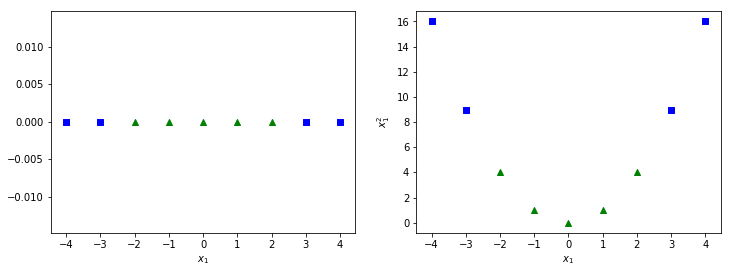

In [35]:
X_none = range(-4, 5)
y_none = [0, 0, 1, 1, 1, 1, 1, 0, 0]
plt.figure(12, figsize=(12, 9))
plt.subplot(221)
X_none_pos = [x_i for i, x_i in enumerate(X_none) if y_none[i] == 1]
X_none_neg = [x_i for i, x_i in enumerate(X_none) if y_none[i] == 0]
plt.scatter(X_none_pos, [0] * len(X_none_pos), c='g', marker='^')
plt.scatter(X_none_neg, [0] * len(X_none_neg), c='b', marker='s')
plt.xlabel("$x_1$")
plt.subplot(222)
X_none2 = [i ** 2 for i in X_none]
X_none_pos2 = [x_i for i, x_i in enumerate(X_none2) if y_none[i] == 1]
X_none_neg2 = [x_i for i, x_i in enumerate(X_none2) if y_none[i] == 0]
plt.scatter(X_none_pos, X_none_pos2, c='g', marker='^')
plt.scatter(X_none_neg, X_none_neg2, c='b', marker='s')
plt.xlabel("$x_1$")
_ = plt.ylabel("$x_1^2$")

这样使用多项式特征，非线性可分数据集就可以变成线性可分的数据集，从而利用SVM对非线性可分数据集进行分类。

In [8]:
def plot_decision_bundary(estimator, X, y, title=None, num=100):
    X1_lin = np.linspace(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5, num=num)
    X2_lin = np.linspace(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5, num=num)
    X11, X22 = np.meshgrid(X1_lin, X2_lin)
    Z = estimator.predict(np.c_[X11.ravel(), X22.ravel()]).reshape(X11.shape)
    plt.contourf(X1_lin, X2_lin, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    if title:
        plt.title(title)

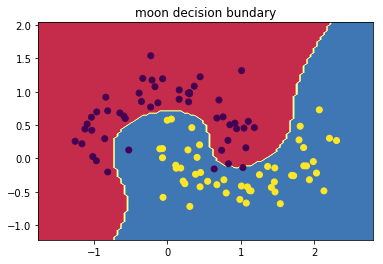

In [9]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
    ('poly_features', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('svm_clf', LinearSVC(C=10, loss='hinge'))
])
X_, y_ = make_moons(n_samples=100, noise=0.2)
polynomial_svm_clf.fit(X_, y_)
plot_decision_bundary(polynomial_svm_clf, X_, y_, 'moon decision bundary')

moon数据集的决策边界，可以看到非线性数据被很好的划分开了。

## 多项式核

为什么使用多项式核：低次数的多项式不能处理非常复杂的数据集；高次数的多项式却产生了大量的特征，使模型变慢。

**核技巧**可以和多项式特征一样好的结果，但是不会增加特征。

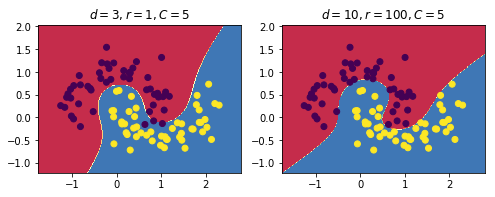

In [10]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='poly', degree=3, coef0=1, C=5))
])
poly_kernel_svm_clf.fit(X_, y_)
plt.figure(12, figsize=(8, 6))
plt.subplot(221)
plot_decision_bundary(poly_kernel_svm_clf, X_, y_, title="$d=3, r=1, C=5$", num=200)
poly_kernel_svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='poly', degree=10, coef0=100, C=5))
])
poly_kernel_svm_clf.fit(X_, y_)
plt.subplot(222)
plot_decision_bundary(poly_kernel_svm_clf, X_, y_, title="$d=10, r=100, C=5$", num=200)

通常使用网格搜索找到最优超参数。

## 增加相似特征

使用相似函数，计算每个样本和特定地标的相似度，从而产生特征转换后的数据集。

shape(m, n) -> shape(m, m)

RBF:
$$\phi_{\gamma}(x, l) = exp(-\gamma \lVert x-l \rVert ^ 2)$$

## 高斯RBF核

高斯核计算成本更低，特别是在大规模的训练集上。

In [18]:
def rbf_decision_bundary(gamma=5, C=0.001):
    rbf_kernel_svm_clf = Pipeline((
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
    ))
    rbf_kernel_svm_clf.fit(X_, y_)
    return rbf_kernel_svm_clf

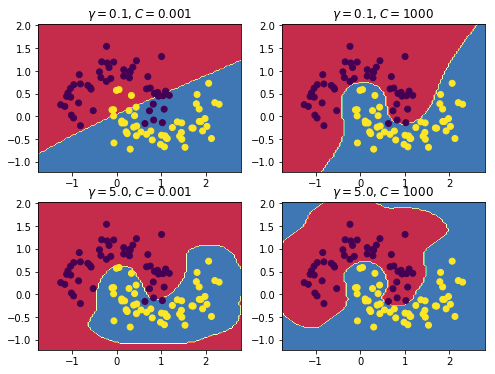

In [36]:
plt.figure(22, figsize=(8, 6))
for i, (gamma, C) in enumerate([(0.1, 0.001), (0.1, 1000), (5., 0.001), (5., 1000)]):
    plt.subplot(int('22%s' % (i + 1)))
    estimator = rbf_decision_bundary(gamma, C)
    plot_decision_bundary(estimator, X_, y_, title='$\gamma=%s, C=%s$' % (gamma, C))

In [37]:
def rbf(X, l, gamma=0.001):
    return np.exp(-gamma * (X-l)**2)

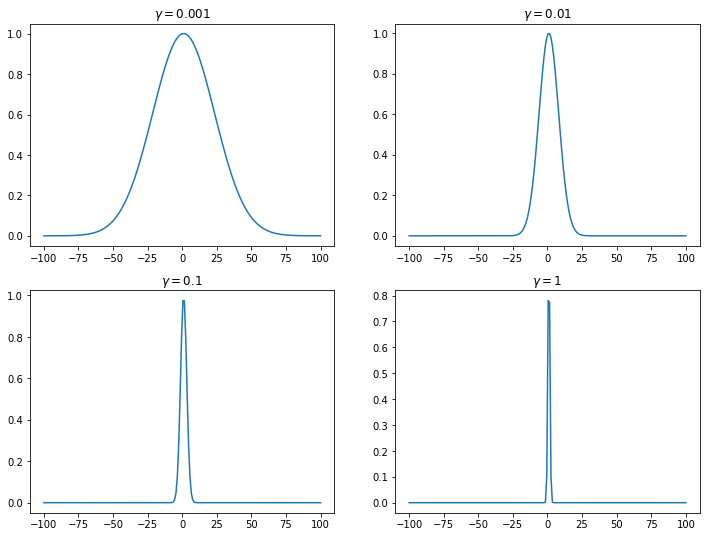

In [54]:
plt.figure(22, figsize=(12, 9))
X_rbf = np.linspace(-100, 100, num=200)
for i, gamma in enumerate([0.001, 0.01, 0.1, 1], 1):
    plt.subplot(int('22%s' % i))
    y_rbf = rbf(X_rbf, l=1, gamma=gamma)
    plt.plot(X_rbf, y_rbf)
    plt.title("$\gamma=%s$" % gamma)

增大 $\gamma$ 使钟形曲线更窄，导致每个样本的影响范围变得更小。

所以，如果过拟合，应该减小 $\gamma$，如果欠拟合，则增大 $\gamma$

**其他核函数**

1. 文本文档或者DNA序列进行分类：
    字符串核(String kernels) -> SSK核(string subsequence kernel)或者基于编辑距离(Levenshtein distance)的核函数

tricks:
1. 首先尝试线性核函数( `LinearSVC` 比 `SVC(kernel="linear")` 要快得多)
2. 训练集不太大：RBF
3. 空闲时间和计算能力：交叉验证和网格搜索

## 计算复杂性

1. `LinearSVC` 基于 `liblinear` 库，不支持核技巧，训练时间复杂度大约为 $O(m×n)$
2. 提高精度，可以减小容差 $\epsilon$ (sklearn中成为 `tol`)
3. `SVC` 基于 `libsvm`，支持核技巧，训练时间复杂度大约为 $O(m^2 × n)$ 和 $O(m^3 × n)$ 之间
4. `SVC` 能对特征数量很好的缩放，尤其对稀疏矩阵。

In [20]:
import pandas as pd

In [24]:
df_ = pd.DataFrame({
    'class': ['LinearSVC', 'SGDClassifier', 'SVC'], 
    'Time Complexity': ['O(m × n)', 'O(m × n)', 'O(m^2 × n) to O(m^3 × n)'],
    'Out-of-core support': ['No', 'Yes', 'No'],
    'Scaling required': ['Yes', 'Yes', 'Yes'],
    'Kernel trick': ['No', 'No', 'Yes']
})
df_ = df_[['class', 'Time Complexity', 'Out-of-core support', 'Scaling required', 'Kernel trick']]
df_

,class,Time Complexity,Out-of-core support,Scaling required,Kernel trick
0,LinearSVC,O(m × n),No,Yes,No
1,SGDClassifier,O(m × n),Yes,Yes,No
2,SVC,O(m^2 × n) to O(m^3 × n),No,Yes,Yes


# SVM回归

逆转我们的目标：

不是试图在两个类别之间找到尽可能大的“街道”(间隔)，而是限制间隔违规情况下，尽量放置更多的样本在“街道”上。

“街道”的宽度由超参数 $\epsilon$ 控制。

其他和 `SVC` 基本差不多

# 背后机制

$w$: 权重

$b$: 偏置

## 决策函数和预测

线性SVM:
$$\hat{y} = \begin{cases} 0&, if\ W^T \cdot X + b < 0, \\ 1&, if\ W^T \cdot X+ b ≥ 0 \end{cases}$$

训练意味着，找到 $w$ 和 $b$ 值使得这一个间隔尽可能大，同时避免间隔违规或限制它们。

## 训练目标

决策函数的斜率等于 $\lVert w \rVert$，权重向量 $w$ 越小，间隔越大。

我们的目标就是最小化 $\lVert w \rVert$，从而获得大的间隔。

所有样本可以表示为：$t^{(i)}(w^Tx^{(i)} + b) ≥ 1$，其中，$t^{(i)} = \begin{cases} 1 &, y^{(i)} = 1 \\ -1 &, y^{(i)} = 0 \end{cases}$

**硬间隔分类器表示为：(*公式格式待调优*)**

$\begin{equation*}\begin{aligned} \underset{w, b}{\text{minimize}}  && \frac{1}{2}W^T \cdot W \\ \text{subject to} && t^{(i)}(W^T \cdot X^{(i)} + b) ≥ 1\ \ for\ i = 1,2, \cdots, m \end{aligned} \end{equation*}$

我们最小化 $1/ 2w^T w$ 而不是 $\lVert w \rVert$，因为 $\lVert w \rVert$ 在 `w=0` 处不可微。优化算法在可微函数表现更好。

**软间隔分类**:

$\begin{equation*}\begin{aligned} \underset{w, b, \zeta}{\text{minimize}}  && \frac{1}{2}W^T \cdot W + C\sum_{i=1}^m \zeta^{(i)}\\ \text{subject to} && t^{(i)}(W^T \cdot X^{(i)} + b) ≥ 1 - \zeta^{(i)}\ and\ \zeta^{(i)} ≥ 0\ \ for\ i = 1,2, \cdots, m \end{aligned} \end{equation*}$

其中， $\zeta^{(i)}$ 表示第 $i$ 个样本允许违规间隔的程度。

超参数 $C$ 允许我们再两个目标之间权衡。(减小间隔违规，增大间隔)

## 二次规划

## 对偶问题

## 核化支持向量机

2次多项式映射函数：

$$\phi(X) = \phi \left(\left(\begin{matrix} x_1 \\ x_2 \end{matrix}\right)\right) = \left(\begin{matrix} x_1^2 \\ \sqrt{2}x_1 x_2 \\ x_2^2 \end{matrix} \right)$$

应用这个2次多项式映射后，计算转换后的向量的点积：
$$
\begin{aligned} 
    \phi(\mathbf{a})^T \cdot \phi(\mathbf{b}) 
    &= \left(\begin{matrix} a_1^2 \\ \sqrt{2}a_1 a_2 \\ a_2^2\end{matrix}\right)^T \cdot \left( \begin{matrix} b_1^2 \\ \sqrt{2}b_1 b_2 \\ b_2^2 \end{matrix}\right)= a_1^2 b_1^2 + 2 a_1 b_1 a_2 b_2 + a_2^2 b_2^2 \\ 
    &= (a_1 b_1 + a_2 b_2)^2 = \left(\left(\begin{matrix} a_1 \\ a_2 \end{matrix}\right)^T \cdot \left(\begin{matrix} b_1 \\ b_2 \end{matrix} \right)\right)^2 = (\mathbf{a}^T \cdot \mathbf{b})^2
\end{aligned}$$

转换后的向量的点积等于原始向量点积的**平方**： $\phi(a)^T \phi(b) = (a^T b)^2$

如果应用转换 $\phi$ 到所有的训练向本，对偶问题将会包含点积 $\phi (x^{(i)})^T \phi(x^{(j)})$。

于是如果 $\phi$ 是2次多项式转换，实际上你不用对训练样本进行转换，仅仅需要在公式中，将点积替换成它点积的平方。

函数 $K(a, b) = (a^T b)^2$ 被称为二次多项式核(polynomial kernel)。

**常用的核函数：**

Linear: $K(\mathbf{a}, \mathbf{b}) = \mathbf{a}^T \cdot \mathbf{b}$

Polynomial: $K(\mathbf{a}, \mathbf{b}) = (\gamma\mathbf{a}^T \cdot \mathbf{b} + r)^d$

Gaussian RBF: $K(\mathbf{a}, \mathbf{b}) = exp(-\gamma\lVert\mathbf{a} - \mathbf{b}\rVert^2)$

Sigmoid: $K(\mathbf{a}, \mathbf{b}) = tanh(\gamma\mathbf{a}^T \cdot \mathbf{b} + r)$

**Nercer定理**

$K$ 函数在参数内必须是连续，对称。 $K(a, b) = K(b, a)$，那么存在函数 $\phi$，将 $a$ 和 $b$ 映射到另一个空间，有：
$K(a, b) = \phi(a)^T (b)$